In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import json
import matplotlib
import matplotlib.font_manager
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import seaborn as sns
from compose import CompositionAgent

matplotlib.use("Agg")
sns.set(style="white", font="Arial")
colors = sns.color_palette("Paired", n_colors=12).as_hex()


In [5]:
path = "~/concurrent/rl/log/composition/raisimGymTorch.env.bin.pointmass1d/"
exp_path = path+"2023-01-27-17-04-49/"
cfg_path = exp_path+"cfg"
model_path = exp_path+"model100/"

with open(cfg_path) as json_file:
	cfg = json.load(json_file)

agent = CompositionAgent(cfg)
agent.load_torch_model(model_path)

### Analysis

In [6]:
n_s = 30

In [7]:
def add_3d_plot(ax, d0, d1, fn, name, zm, s=0.4):
    df = pd.DataFrame(np.concatenate([d0, d1, fn], 1), columns=[*name])
    df = df.sort_values(by=name[2])

    x = df[name[0]].to_numpy()
    y = df[name[1]].to_numpy()
    z = df[name[2]].to_numpy()

    color = cm.rainbow(np.linspace(0, 1, df[name[2]].to_numpy().shape[0]))
    ax.scatter(x, y, z, s=s, color=color)
    ax.set_zlim(zm[0], zm[1])

    ax.set_title(name[2])
    ax.set_xlabel(name[0])
    ax.set_ylabel(name[1])
    ax.set_zlabel(name[2])

    ax.yaxis.set_major_locator(LinearLocator(5))
    ax.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))


def add_2d_plot(ax, d0, d1, name,s=0.4):
    df = pd.DataFrame(np.concatenate([d0, d1], 1), columns=[*name])

    x = df[name[0]].to_numpy()
    y = df[name[1]].to_numpy()

    ax.scatter(x, y, s=s)
    ax.set_xlabel(name[0])
    ax.set_ylabel(name[1])

    ax.yaxis.set_major_locator(LinearLocator(5))
    ax.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
    
def detach_ts(inp):
    return inp.cpu().detach().numpy()


In [8]:
env = agent.env
device = agent.device
obs_dim = agent.observation_dim
feature_dim = agent.feature_dim
act_dim = agent.action_dim

w=agent.w
policy = agent.policy
sf = agent.sf

AttributeError: 'SACAgent' object has no attribute 'sf'

In [ ]:
dim=3
s_x = np.linspace(-25, 25, n_s)
s_y = np.zeros([n_s**dim,1])
s_z = np.zeros([n_s**dim,1])
s_rotmat = np.zeros([n_s**dim,9])
s_vx = np.linspace(-10, 10, n_s)
s_vy = np.zeros([n_s**dim,1])
s_vz = np.zeros([n_s**dim,1])
s_ang = np.zeros([n_s**dim,3])
act = np.linspace(-1, 1, n_s)
s_x, s_vx, act = np.meshgrid(s_x, s_vx, act)
s_x = s_x.reshape(-1,1)
s_vx = s_vx.reshape(-1,1)
a_grid = act.reshape(-1,1)

s_grid = np.concatenate([s_x, s_y, s_z, s_rotmat, s_vx, s_vy,s_vz,s_ang],1)
s_grid_ts = torch.tensor(s_grid).float().reshape(-1, obs_dim).to(device)
a_grid_ts = torch.tensor(a_grid).float().reshape(-1, act_dim).to(device)

In [ ]:
w_x = np.array([1,0,0,0,0,0,0])
w_vx = np.array([0,0,0,1,0,0,0])
w_suc = np.array([0,0,0,0,0,0,1])
wtask_ts = np.array([1,0,0,1,0,0,0])

wx_ts = torch.tensor(w_x,dtype=torch.float32).to(device)
wvx_ts = torch.tensor(w_vx,dtype=torch.float32).to(device)
wsuc_ts = torch.tensor(w_suc,dtype=torch.float32).to(device)
wtask_ts =  torch.tensor(wtask_ts,dtype=torch.float32).to(device)


In [ ]:
sfs1, sfs2 = sf(s_grid_ts, a_grid_ts)
sfs_grid = torch.min(sfs1, sfs2) #[N, H, F]
sfs_x_grid = sfs_grid[:,0,:]
sfs_vx_grid = sfs_grid[:,3,:]
sfs_suc_grid = sfs_grid[:,6,:]
q_x_grid = torch.sum(sfs_x_grid * wx_ts, 1, keepdim=True) 
q_vx_grid = torch.sum(sfs_vx_grid * wvx_ts, 1, keepdim=True)
q_suc_grid = torch.sum(sfs_suc_grid * wsuc_ts, 1, keepdim=True)
q_x_grid=detach_ts(q_x_grid)
q_vx_grid=detach_ts(q_vx_grid)
q_suc_grid=detach_ts(q_suc_grid)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


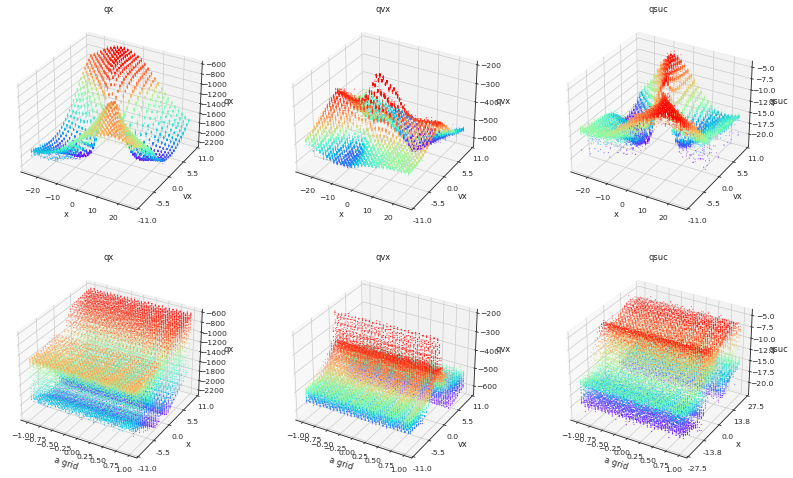

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=(10, 13), dpi=50)
f = 2,3

qx_range = [np.min(q_x_grid),np.max(q_x_grid)]
qvx_range = [np.min(q_vx_grid),np.max(q_vx_grid)]
qsuc_range = [np.min(q_suc_grid), np.max(q_suc_grid)]
a_range=[-1,1]

ax = fig.add_subplot(*f, 1, projection='3d')
add_3d_plot(ax, s_x, s_vx, q_x_grid, ["x","vx","qx"], zm=qx_range)
ax = fig.add_subplot(*f, 2, projection='3d')
add_3d_plot(ax, s_x, s_vx, q_vx_grid, ["x","vx","qvx"], zm=qvx_range)
ax = fig.add_subplot(*f, 3, projection='3d')
add_3d_plot(ax, s_x, s_vx, q_suc_grid, ["x","vx","qsuc"], zm=qsuc_range)
ax = fig.add_subplot(*f, 4, projection='3d')
add_3d_plot(ax, a_grid, s_vx, q_x_grid, ["a grid","x","qx"], zm=qx_range)
ax = fig.add_subplot(*f, 5, projection='3d')
add_3d_plot(ax, a_grid, s_vx, q_vx_grid, ["a grid","vx","qvx"], zm=qvx_range)
ax = fig.add_subplot(*f, 6, projection='3d')
add_3d_plot(ax, a_grid, s_x, q_suc_grid, ["a grid","x","qsuc"], zm=qsuc_range)

plt.subplots_adjust(left=0.1,
                    right=1.7, 
                    bottom=0.1, 
                    top=0.8, 
                    wspace=0.1, 
                    hspace=0.2)

plt.show()

sweep the whole state and action space 
- L: sf x for the policy x
- M: sf vx for the policy vx
- R: sf suc for the policy suc

In [ ]:
x_lim_a = [-5,-3]
vx_lim_a = [-0.5,0]
x_lim_b = [3,5]
vx_lim_b = [0,0.5]

slice_a = (s_x>x_lim_a[0]) & (s_x<x_lim_a[1]) & (s_vx>vx_lim_a[0]) & (s_vx<vx_lim_a[1])
slice_b = (s_x>x_lim_b[0]) & (s_x<x_lim_b[1]) & (s_vx>vx_lim_b[0]) & (s_vx<vx_lim_b[1])

x_slice_a=s_x[slice_a][:,None]
a_slice_a=a_grid[slice_a][:,None]
q_x_slice_a=q_x_grid[slice_a][:,None]
q_vx_slice_a=q_vx_grid[slice_a][:,None]
q_suc_slice_a=q_suc_grid[slice_a][:,None]

x_slice_b=s_x[slice_b][:,None]
a_slice_b=a_grid[slice_b][:,None]
q_x_slice_b=q_x_grid[slice_b][:,None]
q_vx_slice_b=q_vx_grid[slice_b][:,None]
q_suc_slice_b=q_suc_grid[slice_b][:,None]

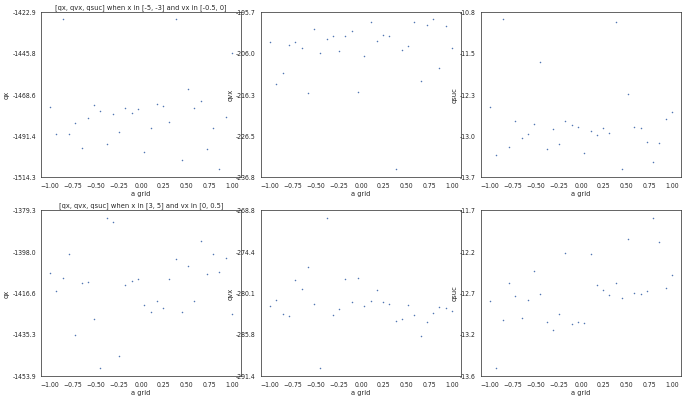

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=(10, 13), dpi=40)
f = 2,3

qx_range = [np.min(q_x_grid),np.max(q_x_grid)]
qvx_range = [np.min(q_vx_grid),np.max(q_vx_grid)]
qsuc_range = [np.min(q_suc_grid), np.max(q_suc_grid)]
a_range=[-1,1]

ax = fig.add_subplot(*f, 1)
ax.set_title(f"[qx, qvx, qsuc] when x in {x_lim_a} and vx in {vx_lim_a}")
add_2d_plot(ax, a_slice_a, q_x_slice_a, ["a grid", "qx"],s=3)
ax = fig.add_subplot(*f, 2)
add_2d_plot(ax, a_slice_a, q_vx_slice_a, ["a grid","qvx"],s=3)
ax = fig.add_subplot(*f, 3)
add_2d_plot(ax, a_slice_a, q_suc_slice_a, ["a grid", "qsuc"],s=3)
ax = fig.add_subplot(*f, 4)
ax.set_title(f"[qx, qvx, qsuc] when x in {x_lim_b} and vx in {vx_lim_b}")
add_2d_plot(ax, a_slice_b, q_x_slice_b, ["a grid", "qx"],s=3)
ax = fig.add_subplot(*f, 5)
add_2d_plot(ax, a_slice_b, q_vx_slice_b, ["a grid","qvx"],s=3)
ax = fig.add_subplot(*f, 6)
add_2d_plot(ax, a_slice_b, q_suc_slice_b, ["a grid", "qsuc"],s=3)

plt.subplots_adjust(left=0.1,
                    right=1.7, 
                    bottom=0.1, 
                    top=0.8, 
                    wspace=0.1, 
                    hspace=0.2)

plt.show()

zoom in to the state 
- top row: x in [0,3] and vx close to 0
- bot row: x in [-3,0] and vx close to 0

we see that when x>0, q value is higher when applying a<0 for all q values, and vice versa

In [ ]:
a_dist, _, a_mean = agent.policy(s_grid_ts)

ax_dist_ts = a_dist[:,0]
avx_dist_ts = a_dist[:,3]
asuc_dist_ts = a_dist[:,6]
ax_mean_ts = a_mean[:,0]
avx_mean_ts = a_mean[:,3]
asuc_mean_ts = a_mean[:,6]

ax_dist=detach_ts(ax_dist_ts)
avx_dist=detach_ts(avx_dist_ts)
asuc_dist=detach_ts(asuc_dist_ts)
ax_mean=detach_ts(ax_mean_ts)
avx_mean=detach_ts(avx_mean_ts)
asuc_mean=detach_ts(asuc_mean_ts)


In [ ]:
sfs1, sfs2 = sf(s_grid_ts, ax_dist_ts)
sfs_x = torch.min(sfs1, sfs2) #[N, H, F]
sfs1, sfs2 = sf(s_grid_ts, avx_dist_ts)
sfs_vx = torch.min(sfs1, sfs2) #[N, H, F]
sfs1, sfs2 = sf(s_grid_ts, asuc_dist_ts)
sfs_suc = torch.min(sfs1, sfs2) #[N, H, F]

sf_x = sfs_x[:,0,:] #[N,F]
sf_vx = sfs_vx[:,3,:] #[N,F]
sf_suc = sfs_suc[:,6,:] #[N,F]

q_x = torch.sum(sf_x * wx_ts, 1, keepdim=True) 
q_vx = torch.sum(sf_vx * wvx_ts, 1, keepdim=True)
q_suc = torch.sum(sf_suc * wsuc_ts, 1, keepdim=True)

q_task0 = torch.sum(sf_x * wtask_ts, 1, keepdim=True) 
q_task1 = torch.sum(sf_vx * wtask_ts, 1, keepdim=True)
q_task2 = torch.sum(sf_suc * wtask_ts, 1, keepdim=True)
q_task=torch.concat([q_task0, q_task1, q_task2],1)
q_task,_=torch.max(q_task,1, keepdim=True)

sf_x=detach_ts(sf_x)
sf_vx=detach_ts(sf_vx)
sf_suc=detach_ts(sf_suc)
q_x=detach_ts(q_x)
q_vx=detach_ts(q_vx)
q_suc=detach_ts(q_suc)
q_task=detach_ts(q_task)

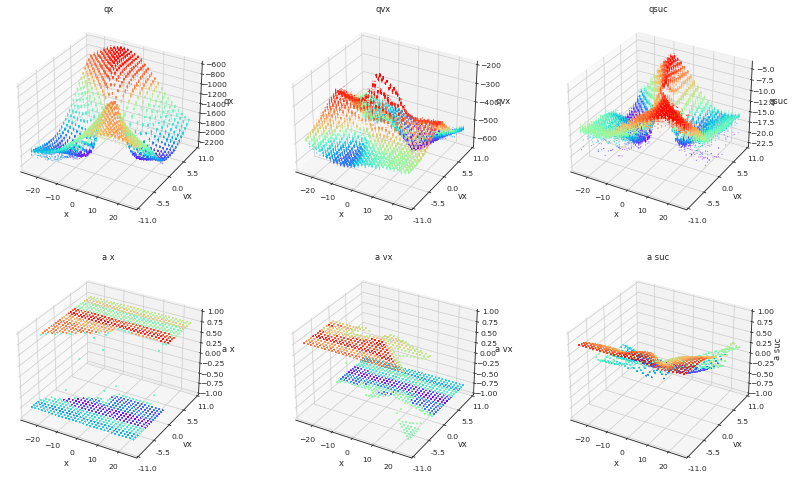

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=(10, 13), dpi=50)
f = 2,3

qx_range = [np.min(q_x),np.max(q_x)]
qvx_range = [np.min(q_vx),np.max(q_vx)]
qsuc_range = [np.min(q_suc), np.max(q_suc)]
a_range=[-1,1]

ax = fig.add_subplot(*f, 1, projection='3d')
add_3d_plot(ax, s_x, s_vx, q_x, ["x","vx","qx"], zm=qx_range)
ax = fig.add_subplot(*f, 2, projection='3d')
add_3d_plot(ax, s_x, s_vx, q_vx, ["x","vx","qvx"], zm=qvx_range)
ax = fig.add_subplot(*f, 3, projection='3d')
add_3d_plot(ax, s_x, s_vx, q_suc, ["x","vx","qsuc"], zm=qsuc_range)
ax = fig.add_subplot(*f, 4, projection='3d')
add_3d_plot(ax, s_x, s_vx, ax_mean, ["x","vx","a x"], zm=a_range)
ax = fig.add_subplot(*f, 5, projection='3d')
add_3d_plot(ax, s_x, s_vx, avx_mean, ["x","vx","a vx"], zm=a_range)
ax = fig.add_subplot(*f, 6, projection='3d')
add_3d_plot(ax, s_x, s_vx, asuc_mean, ["x","vx","a suc"], zm=a_range)
plt.subplots_adjust(left=0.1,
                    right=1.7, 
                    bottom=0.1, 
                    top=0.8, 
                    wspace=0.1, 
                    hspace=0.2)

plt.show()

here we change the sampled action from sweep actions to actual policy actions, i.e. a = pi(s)
and identify the corresponding q value and policy action distribtion
for example, 
- top left: we use sf x to evaluate q value of policy x. we can see that q value is the highest when both x and vx are close to 0
- bot left: policy x action mean given state, x and vx. the strategy is to apply positive action when vx<0 (red)

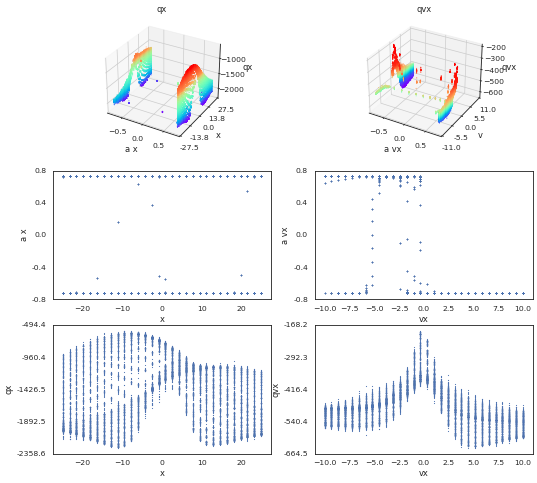

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=(6, 12.5), dpi=50)
f = 3,2

qx_range = [np.min(q_x),np.max(q_x)]
qvx_range = [np.min(q_vx),np.max(q_vx)]
qsuc_range = [np.min(q_suc), np.max(q_suc)]

ax = fig.add_subplot(*f, 1, projection='3d')
add_3d_plot(ax, ax_mean, s_x, q_x, ["a x","x","qx"], zm=qx_range)
ax = fig.add_subplot(*f, 2, projection='3d')
add_3d_plot(ax, avx_mean, s_vx, q_vx, ["a vx","v","qvx"], zm=qvx_range)

ax = fig.add_subplot(*f, 3)
add_2d_plot(ax, s_x, ax_mean, ["x", "a x"])
ax = fig.add_subplot(*f, 4)
add_2d_plot(ax, s_vx, avx_mean, ["vx","a vx"])

ax = fig.add_subplot(*f, 5)
add_2d_plot(ax, s_x, q_x, ["x", "qx"])
ax = fig.add_subplot(*f, 6)
add_2d_plot(ax, s_vx, q_vx, ["vx", "qvx"])

plt.subplots_adjust(left=0.1,
                    right=1.7, 
                    bottom=0.1, 
                    top=0.8, 
                    wspace=0.2, 
                    hspace=0.2)

plt.show()

the relation between state, action, and q-value
- right mid: policy vx strategy, when vx > 0, act = -0.8
- right bottom: vx=0 has the largest q value

In [ ]:
x_lim_a = [-5,-3]
vx_lim_a = [-0.5,0]
x_lim_b = [3,5]
vx_lim_b = [0,0.5]

slice_a = (s_x>x_lim_a[0]) & (s_x<x_lim_a[1]) & (s_vx>vx_lim_a[0]) & (s_vx<vx_lim_a[1])
x_slice_a=s_x[slice_a][:,None]
a_slice_a=a_grid[slice_a][:,None]
a_test_slice_a=ax_dist[slice_a][:,None]
q_x_slice_a=q_x_grid[slice_a][:,None]

slice_b = (s_x>x_lim_b[0]) & (s_x<x_lim_b[1]) & (s_vx>vx_lim_b[0]) & (s_vx<vx_lim_b[1])
x_slice_b=s_x[slice_b][:,None]
a_slice_b=a_grid[slice_b][:,None]
a_test_slice_b=ax_dist[slice_b][:,None]
q_x_slice_b=q_x_grid[slice_b][:,None]

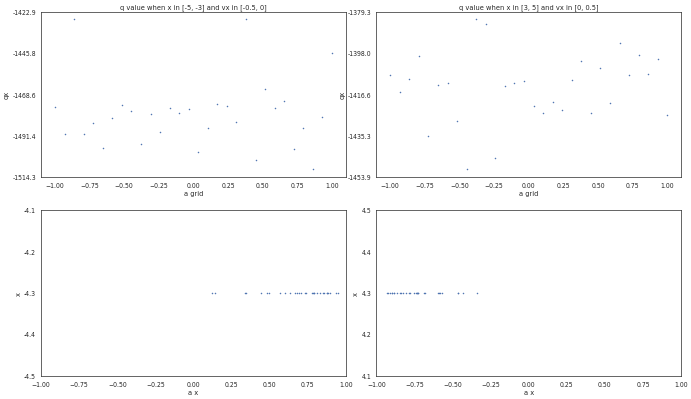

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=(10, 13), dpi=40)
f = 2,2

ax = fig.add_subplot(*f, 1)
ax.set_title(f"q value when x in {x_lim_a} and vx in {vx_lim_a}")
add_2d_plot(ax, a_slice_a, q_x_slice_a, ["a grid", "qx"],s=3)
ax = fig.add_subplot(*f, 2)
ax.set_title(f"q value when x in {x_lim_b} and vx in {vx_lim_b}")
add_2d_plot(ax, a_slice_b, q_x_slice_b, ["a grid", "qx"],s=3)
ax = fig.add_subplot(*f, 3)
ax.set_xlim([-1,1])
add_2d_plot(ax, a_test_slice_a, x_slice_a, ["a x","x"],s=3)
ax = fig.add_subplot(*f, 4)
ax.set_xlim([-1,1])
add_2d_plot(ax, a_test_slice_b, x_slice_b, ["a x","x"],s=3)


plt.subplots_adjust(left=0.1,
                    right=1.7, 
                    bottom=0.1, 
                    top=0.8, 
                    wspace=0.1, 
                    hspace=0.2)

plt.show()

in a certain state (L: x[0,3], R: x[-3,0]. vx~0)
- top row: q value varies across different action
- borrom row: action distribution of the policy

### compositional action

In [ ]:
w_x = np.array([1,0,0,0,0,0,0])
w_vx = np.array([0,0,0,1,0,0,0])
w_suc = np.array([0,0,0,0,0,0,1])
w_task = np.array([1,0,0,3,0,0,0])

exploitation = True

In [ ]:
wx_ts = torch.tensor(w_x,dtype=torch.float32).to(device)
wvx_ts = torch.tensor(w_vx,dtype=torch.float32).to(device)
wsuc_ts = torch.tensor(w_suc,dtype=torch.float32).to(device)
wtask_ts =  torch.tensor(w_task,dtype=torch.float32).to(device)

wx = wx_ts.tile((n_s**dim,1))
wvx = wvx_ts.tile((n_s**dim,1))
wsuc = wsuc_ts.tile((n_s**dim,1))
wtask = wtask_ts.tile((n_s**dim,1))

In [ ]:
a_dist, _, a_mean = agent.policy(s_grid_ts)

ax_dist_ts = a_dist[:,0]
avx_dist_ts = a_dist[:,3]
asuc_dist_ts = a_dist[:,6]
ax_mean_ts = a_mean[:,0]
avx_mean_ts = a_mean[:,3]
asuc_mean_ts = a_mean[:,6]

ax_dist=detach_ts(ax_dist_ts)
avx_dist=detach_ts(avx_dist_ts)
asuc_dist=detach_ts(asuc_dist_ts)
ax_mean=detach_ts(ax_mean_ts)
avx_mean=detach_ts(avx_mean_ts)
asuc_mean=detach_ts(asuc_mean_ts)

sfs1, sfs2 = sf(s_grid_ts, ax_dist_ts)
sfs_x = torch.min(sfs1, sfs2) #[N, H, F]
sfs1, sfs2 = sf(s_grid_ts, avx_dist_ts)
sfs_vx = torch.min(sfs1, sfs2) #[N, H, F]
sfs1, sfs2 = sf(s_grid_ts, asuc_dist_ts)
sfs_suc = torch.min(sfs1, sfs2) #[N, H, F]

sf_x = sfs_x[:,0,:] #[N,F]
sf_vx = sfs_vx[:,3,:] #[N,F]
sf_suc = sfs_suc[:,6,:] #[N,F]

q_x = torch.sum(sf_x * wx_ts, 1, keepdim=True) 
q_vx = torch.sum(sf_vx * wvx_ts, 1, keepdim=True)
q_suc = torch.sum(sf_suc * wsuc_ts, 1, keepdim=True)

q_task0 = torch.sum(sf_x * wtask_ts, 1, keepdim=True) 
q_task1 = torch.sum(sf_vx * wtask_ts, 1, keepdim=True)
q_task2 = torch.sum(sf_suc * wtask_ts, 1, keepdim=True)
q_task=torch.concat([q_task0, q_task1, q_task2],1)
q_task,_=torch.max(q_task,1, keepdim=True)

sf_x=detach_ts(sf_x)
sf_vx=detach_ts(sf_vx)
sf_suc=detach_ts(sf_suc)
q_x=detach_ts(q_x)
q_vx=detach_ts(q_vx)
q_suc=detach_ts(q_suc)
q_task=detach_ts(q_task)

In [ ]:
if exploitation:
    _, _, a_x_c = agent.policy.compose_action(s_grid_ts, wx)
    _, _, a_vx_c = agent.policy.compose_action(s_grid_ts, wvx)
    _, _, a_task_c = agent.policy.compose_action(s_grid_ts, wtask)
else:
    a_x_c, _, _ = agent.policy.compose_action(s_grid_ts, wx)
    a_vx_c, _, _ = agent.policy.compose_action(s_grid_ts, wvx)
    a_task_c, _, _ = agent.policy.compose_action(s_grid_ts, wtask)
a_x_c = detach_ts(a_x_c)
a_vx_c = detach_ts(a_vx_c)
a_task_c = detach_ts(a_task_c)

agent.sfcpi=False
if exploitation:
    a_x_gpi = agent.exploit(s_grid_ts, wx)
    a_vx_gpi = agent.exploit(s_grid_ts, wvx)
    a_task_gpi = agent.exploit(s_grid_ts, wtask)
else:
    a_x_gpi = agent.explore(s_grid_ts, wx)
    a_vx_gpi = agent.explore(s_grid_ts, wvx)
    a_task_gpi = agent.explore(s_grid_ts, wtask)
a_x_gpi = detach_ts(a_x_gpi)
a_vx_gpi = detach_ts(a_vx_gpi)
a_task_gpi = detach_ts(a_task_gpi)

agent.sfcpi=True
if exploitation:
    a_x_cpi = agent.exploit(s_grid_ts, wx)
    a_vx_cpi = agent.exploit(s_grid_ts, wvx)
    a_task_cpi = agent.exploit(s_grid_ts, wtask)
else:
    a_x_cpi = agent.explore(s_grid_ts, wx)
    a_vx_cpi = agent.explore(s_grid_ts, wvx)
    a_task_cpi = agent.explore(s_grid_ts, wtask)
a_x_cpi = detach_ts(a_x_cpi)
a_vx_cpi = detach_ts(a_vx_cpi)
a_task_cpi = detach_ts(a_task_cpi)

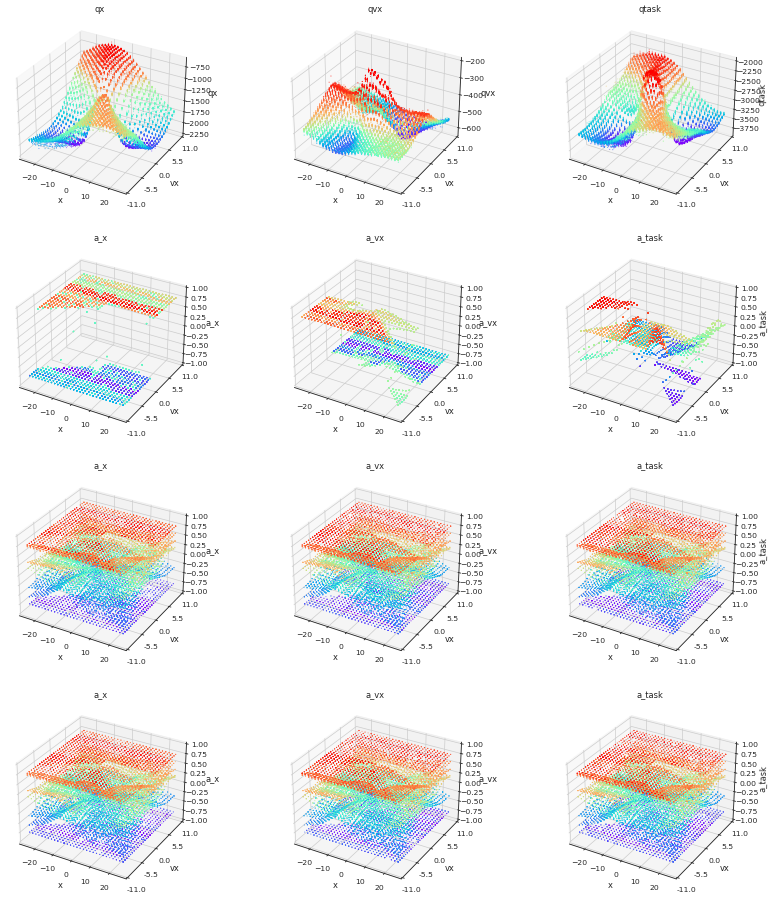

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=(10, 25), dpi=50)
f = 4,3

qtask_range=[np.min(q_task),np.max(q_task)]

ax = fig.add_subplot(*f, 1, projection='3d')
add_3d_plot(ax, s_x, s_vx, q_x, ["x","vx","qx"], zm=qx_range)
ax = fig.add_subplot(*f, 2, projection='3d')
add_3d_plot(ax, s_x, s_vx, q_vx, ["x","vx","qvx"], zm=qvx_range)
ax = fig.add_subplot(*f, 3, projection='3d')
add_3d_plot(ax, s_x, s_vx, q_task, ["x","vx","qtask"], zm=qtask_range)

ax = fig.add_subplot(*f, 4, projection='3d')
ax.set_title("compose action")
add_3d_plot(ax, s_x, s_vx, a_x_c, ["x","vx","a_x"], zm=[-1,1])
ax = fig.add_subplot(*f, 5, projection='3d')
add_3d_plot(ax, s_x, s_vx, a_vx_c, ["x","vx","a_vx"], zm=[-1,1])
ax = fig.add_subplot(*f, 6, projection='3d')
add_3d_plot(ax, s_x, s_vx, a_task_c, ["x","vx","a_task"], zm=[-1,1])

ax = fig.add_subplot(*f, 7, projection='3d')
ax.set_title("gpi")
add_3d_plot(ax, s_x, s_vx, a_x_gpi, ["x","vx","a_x"], zm=[-1,1])
ax = fig.add_subplot(*f, 8, projection='3d')
add_3d_plot(ax, s_x, s_vx, a_vx_gpi, ["x","vx","a_vx"], zm=[-1,1])
ax = fig.add_subplot(*f, 9, projection='3d')
add_3d_plot(ax, s_x, s_vx, a_task_gpi, ["x","vx","a_task"], zm=[-1,1])

ax = fig.add_subplot(*f, 10, projection='3d')
ax.set_title("softmax gpi")
add_3d_plot(ax, s_x, s_vx, a_x_cpi, ["x","vx","a_x"], zm=[-1,1])
ax = fig.add_subplot(*f, 11, projection='3d')
add_3d_plot(ax, s_x, s_vx, a_vx_cpi, ["x","vx","a_vx"], zm=[-1,1])
ax = fig.add_subplot(*f, 12, projection='3d')
add_3d_plot(ax, s_x, s_vx, a_task_cpi, ["x","vx","a_task"], zm=[-1,1])

plt.subplots_adjust(left=0.1,
                    right=1.7, 
                    bottom=0.1, 
                    top=0.8, 
                    wspace=0.1, 
                    hspace=0.2)

plt.show()